# Project 3: Poisonous mushrooms
In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [200]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

from sklearn.mixture import GaussianMixture
import warnings; warnings.simplefilter('ignore')

Load feature names.

In [201]:
feature_names = []
with open('C:\\Users\\I822363\\Documents\\W207\\Data\\mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print('Loaded feature names:', len(feature_names))

Loaded feature names: 126


Loaded feature names: 126
Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [202]:
X, Y = [], []

with open('C:\\Users\\I822363\\Documents\\W207\\Data\\mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


Convert to Data Frames

In [203]:
X_train = pd.DataFrame(data = train_data)
y_train = pd.DataFrame(train_labels)

X_test = pd.DataFrame(data = test_data)
y_test = pd.DataFrame(data = test_labels)

(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

50 principal components are able to explain 98.21 percent of the variance
k: 2 components explain 16.40 percent of the variance
k: 3 components explain 29.73 percent of the variance
k: 4 components explain 39.90 percent of the variance
k: 5 components explain 46.96 percent of the variance
k: 6 components explain 50.83 percent of the variance
k: 7 components explain 54.51 percent of the variance
k: 8 components explain 57.64 percent of the variance
k: 9 components explain 60.37 percent of the variance
k: 10 components explain 62.99 percent of the variance
k: 11 components explain 65.22 percent of the variance
k: 12 components explain 67.27 percent of the variance
k: 13 components explain 69.14 percent of the variance
k: 14 components explain 70.87 percent of the variance
k: 15 components explain 72.56 percent of the variance
k: 16 components explain 74.08 percent of the variance
k: 17 components explain 75.58 percent of the variance
k: 18 components explain 77.01 percent of the variance

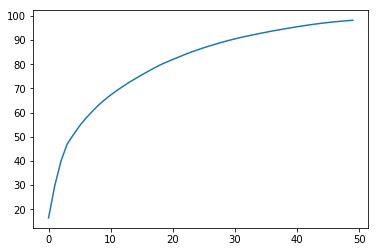

In [204]:
def P1(ip_num_comp = 50):
    pca = PCA(n_components= ip_num_comp)
    pca.fit(X_train)
    print('50 principal components are able to explain %.2f percent of the variance' % (
        np.round(np.sum(pca.explained_variance_ratio_),4) * 100))
    for i in range(1, ip_num_comp + 1):
        cum_var = 100 * np.sum(pca.explained_variance_ratio_[:i])
        print('k: %d components explain %.2f percent of the variance' % (i+1, np.round(cum_var,4)))
    plt.plot(100 * np.cumsum(pca.explained_variance_ratio_))
    return pca
    
pca = P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

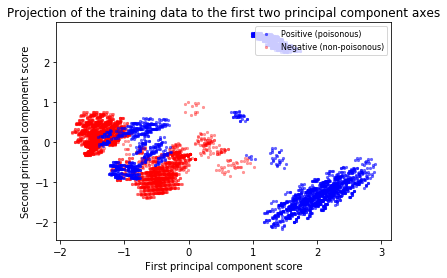

In [205]:
def P2(ip_num_comp = 2):
# Method 3 to carry out PCA 
# from the previously calculated PCA, pick only 2 components
# and separate them into poisonous and non posinous based on labels
# and chart them
    Vt = pca.components_[:2, :]
    M = X_train - X_train.mean()
    U = np.matmul(M, np.transpose(Vt))
    
    # segregate into poisonous and non-poisonous
    poison_data = U[y_train.index[y_train[0] == 1].tolist(), :]
    non_poison_data = U[y_train.index[y_train[0] == 0].tolist(), :]
    
    # Begin plotting
    non_poison = plt.scatter(
        non_poison_data[:,0], non_poison_data[:,1],facecolor='r',marker="o",alpha=.4,s=8,lw=0.3)
    poison = plt.scatter(
        poison_data[:,0],poison_data[:,1],facecolor='b',marker="o",alpha=.6,s=8,lw=0.3)
    plt.xlabel("First principal component score")
    plt.ylabel('Second principal component score')
    plt.title("Projection of the training data to the first two principal component axes")
    plt.legend((poison,non_poison),
           ('Positive (poisonous)', 'Negative (non-poisonous)'),
           scatterpoints=1,
           loc='upper right',
           ncol=1,
           fontsize=8)
    plt.show() 

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

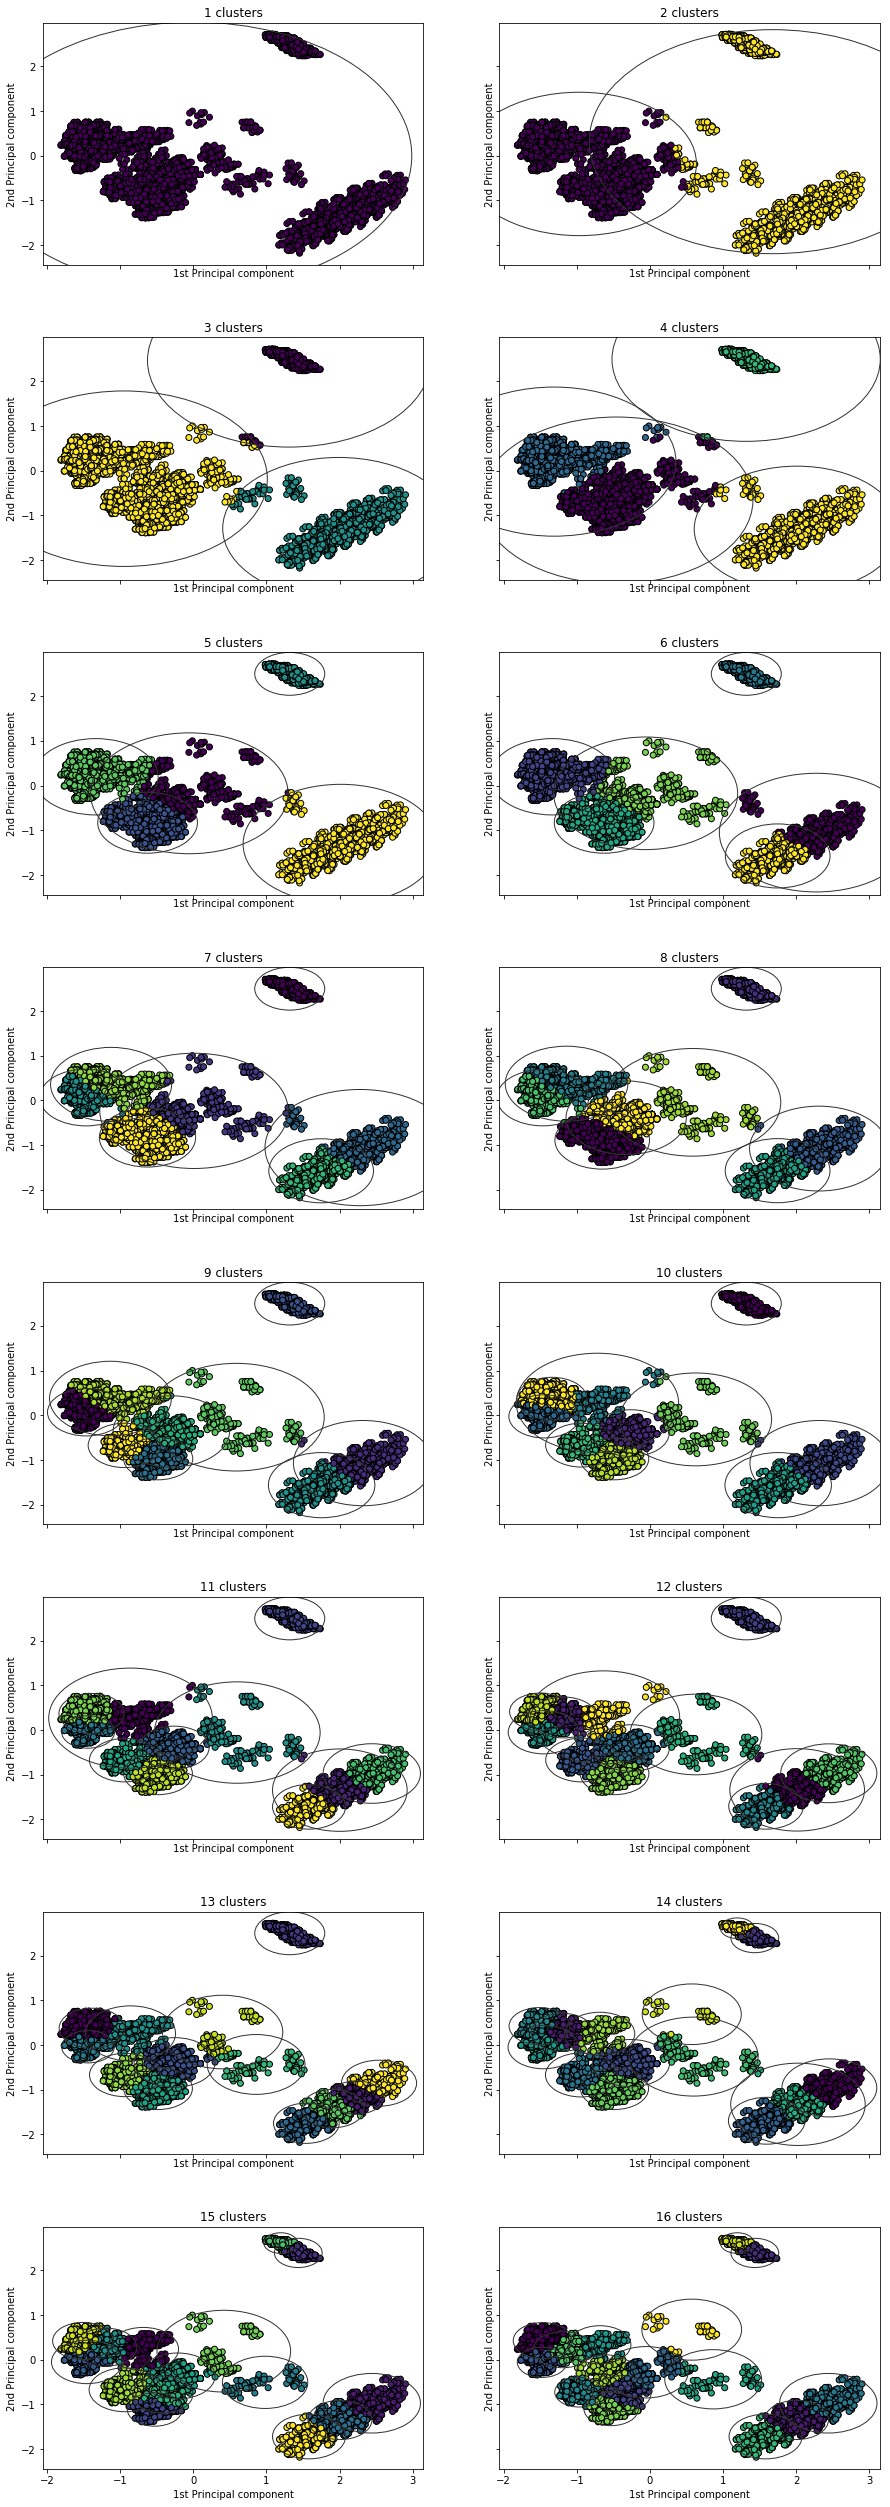

In [206]:
def P3():
    f, axarr = plt.subplots(8, 2, figsize=(15,45))
    f.subplots_adjust(hspace=0.3)

    n_clusters = 0
    for i in range(8):
        for j in range(2):
            n_clusters += 1
            km = KMeans(n_clusters=n_clusters)
            km.fit(X_reduced)
            axarr[i, j].scatter(X_reduced[:, 0], X_reduced[:, 1], c=km.labels_, edgecolor='black')
            axarr[i, j].set_title('%d clusters' % (n_clusters))
            for cc in range(km.cluster_centers_.shape[0]):
                dists = km.transform(X_reduced[km.labels_ == cc])
                radii = np.amax(dists, axis=0)[cc]
                circ = plt.Circle((km.cluster_centers_[cc]), radius = radii, fill=False, ec='0.2')
                ax = axarr[i, j]
                ax.add_patch(circ)
        
    for idx, ax in enumerate(axarr.flat):
        ax.set(xlabel='1st Principal component', ylabel='2nd Principal component')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axarr.flat:
        ax.label_outer()

X_reduced = PCA(n_components = 2).fit_transform(X_train)        
P3()

In [207]:
X_reduced[y_train.index[y_train[0] == 1].tolist(), :]

array([[-1.05434467, -0.8942633 ],
       [-1.1836034 , -0.59804209],
       [-0.92105748, -0.51390462],
       ..., 
       [-0.98473439, -0.8239878 ],
       [-0.99737908, -0.67719101],
       [-0.84782635, -0.52479521]])

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full')

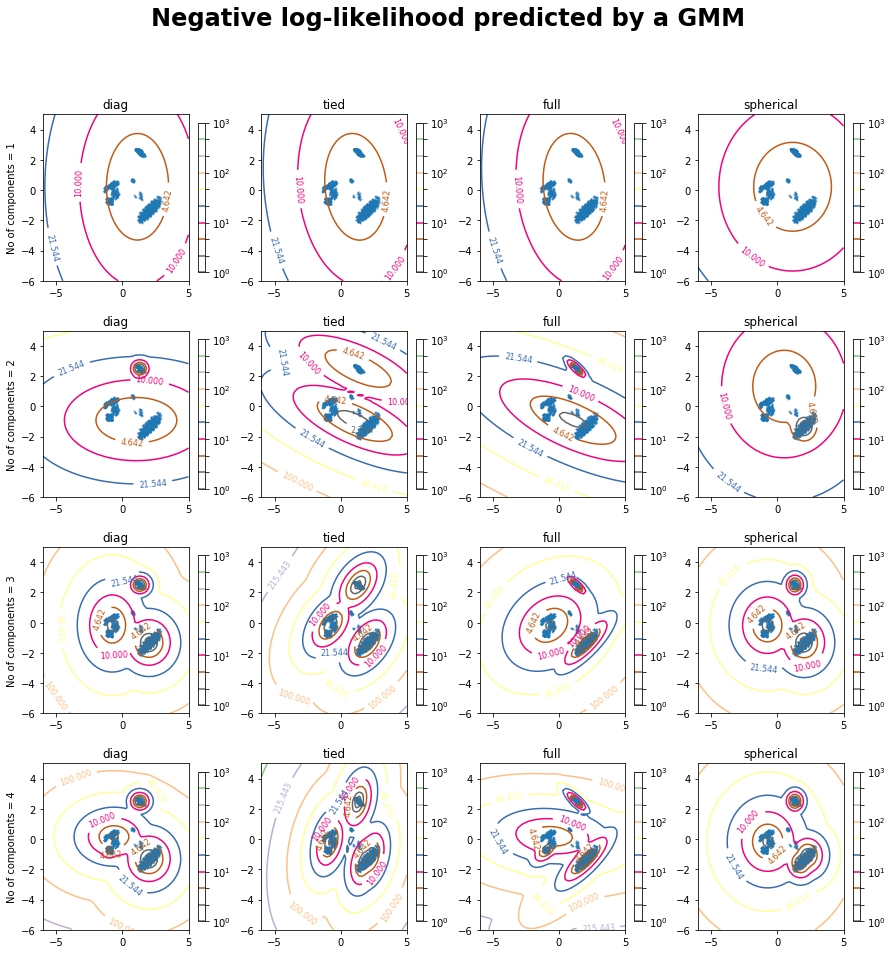

In [213]:
def P4():
    n_samples = 300
    f, axarr = plt.subplots(4, 4, figsize=(15,15))
    f.subplots_adjust(hspace=0.3)
    n_comps = 0
    categories = ['spherical', 'diag', 'tied', 'full']

    #Initialize variables for contour plot
    x = np.linspace(-6., 5.)
    y = np.linspace(-6., 5.)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T

    # Filter and select only the poisonous mushrooms
    X_train_poisonous = X_reduced[y_train.index[y_train[0] == 1].tolist(), :]
    
    #Plot the graphs for upto 4 components
    for i in range(1,17):
        if i % 4 == 1:
            n_comps += 1
        cat = categories[i % 4]
            # fit a Gaussian Mixture Model with two components
        sub1 = plt.subplot(4,4,i)
        gm_mod = GaussianMixture(
                  n_components = n_comps, 
                covariance_type=cat
                )
        gm_mod.fit(X_train_poisonous)
            # display predicted scores by the model as a contour plot
        Z = -gm_mod.score_samples(XX)
        Z = Z.reshape(X.shape)
        CS = plt.contour(
                 X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10), cmap=plt.cm.Accent_r)
        CB = plt.colorbar(CS, shrink=0.9, extend='both')
        plt.scatter(X_train_poisonous[:, 0], X_train_poisonous[:, 1], s=1, alpha=0.5)
        plt.clabel(CS, inline=1, fontsize=8)
        if i % 4 == 1:
            plt.ylabel('No of components = %d' % (n_comps))
        plt.title(cat)
    
    plt.axis('tight')    
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axarr.flat:
        ax.label_outer()
        #ax.set(ylabel='No of components = %d' % ())
    f.suptitle('Negative log-likelihood predicted by a GMM', fontsize = 24, fontweight = 'bold')
        
    
            
P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

Accuracy: 0.951067615658363

Predicted log-likelihood values: warmer colors indicate higher certainty of prediction.


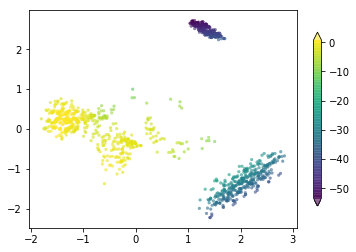

In [290]:
def P5():
### STUDENT START ###
    # project to two dimensions
    pca2 = PCA(n_components=2)
    # transform train and tests sets
    pca2_train = pca2.fit_transform(train_data)
    pca2_test = pca2.transform(test_data)
    # extract positive and negative training data
    pca2_positive = pca2_train[train_labels==1]
    pca2_negative = pca2_train[train_labels==0]
    # fit a GMM to the positive and negative sets
    gmm = GMM(n_components=4, covariance_type='full')
    gmm_pos = gmm.fit(pca2_positive)
    # GMM likelihood is the normal probability, as the logarithm is a homomorphic transformation, we can compare the logs
    # to decide which probability is higher
    pos_loglik = gmm_pos.score(pca2_test)
    gmm_neg = gmm.fit(pca2_negative)
    neg_loglik = gmm_pos.score(pca2_test)
    # Predicted label positive (1) if positive is greater than negative, negative (0) otherwise
    pred_labels = pos_loglik>neg_loglik
    # calculate accuracy
    accuracy = float(np.sum(test_labels==pred_labels))/len(test_labels)
    print('Accuracy: {acc}'.format(acc=accuracy))
    # plot where the model is the most certain
    pred_loglik = pos_loglik if pred_labels is 1 else neg_loglik
    SC = plt.scatter(pca2_test[:,0],pca2_test[:,1],c=pred_loglik,marker="o",alpha=.6,s=8,lw=0.3)
    CB = plt.colorbar(SC, shrink=0.8, extend='both')
    print('\nPredicted log-likelihood values: warmer colors indicate higher certainty of prediction.')
    plt.show()
### STUDENT END ### np.exp(gmm_pos.score(pca2_test))

P5()

(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:
( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters
You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [293]:
def P6():
### STUDENT START ###
    print('Benchamrk P5(): 40 parameters - 0.95 accuracy\n')

    # --------------------------------- Define a GMM fitter ------------------- #

    class GmmFitter():
        '''Fits a GMM, returns accuracy and number of model parameters'''
    
        def __init__(self,n_pca,n_gmm,cov_type):
            '''Initialize a GMM fitter instance'''
            self.n_pca = n_pca
            self.n_gmm = n_gmm
            self.cov_type = cov_type
            if cov_type is 'spherical':
                self.n_cov_pars = 1
            elif cov_type is 'diag':
                self.n_cov_pars = self.n_pca
            elif self.cov_type is 'tied':
                self.n_cov_pars = 0.5*self.n_pca*(self.n_pca+1)
            elif self.cov_type is 'full':
                self.n_cov_pars = 0.5*self.n_pca*(self.n_pca+1)
            else:
                print('Covariance matrix has to be either "spherical", "diag", "tied" or "full".')
            
        @property
        def n_pars(self):
            '''Number of parameters in the model'''
            if self.cov_type is not 'tied':
                return ((self.n_pca+self.n_cov_pars)*self.n_gmm)*2
            else:
                # one covariance matrix estimated for all mixture components
                return (self.n_pca*self.n_gmm+self.n_cov_pars)*2
            
        def fit(self,train_data,test_data,train_labels,test_labels):
            '''Fit GMM and return its accuracy'''
            # project to two dimensions
            pca = PCA(n_components=self.n_pca)
            # transform train and tests sets
            pca_train = pca.fit_transform(train_data)
            pca_test = pca.transform(test_data)
            #fit a GMM 
            gmm = GMM(n_components=self.n_gmm, covariance_type=self.cov_type)
            # extract positive and negative training data
            pca_positive = pca_train[train_labels==1]
            pca_negative = pca_train[train_labels==0]
            gmm_pos = gmm.fit(pca_positive)
            pos_loglik = gmm_pos.score(pca_test)
            gmm_neg = gmm.fit(pca_negative)
            neg_loglik = gmm_pos.score(pca_test)
            # Predicted label positive (1) if positive is greater than negative, negative (0) otherwise
            pred_labels = pos_loglik>neg_loglik
            # calculate accuracy
            accuracy = float(np.sum(test_labels==pred_labels))/len(test_labels)
            return accuracy

    # ------------------- Model selection --------------------------- #
    # define parameter space
    cov_types = ['spherical','diag','tied','full']
    pcas = np.arange(1,25) # spherical cov, 1 GMM, 24 PCAs give 50 parameters
    gmms = np.arange(1,25) # tied cov, 24 GMM, 1 PCA give 50 parameters
    results = {} # create empty dictionary for saving the results in
    # loop over the parameter space
    for cov_type in cov_types:
        for n_pca in pcas:
            for n_gmm in gmms:
                # instantiate a GmmFitter object with the actual parameters
                gmm = GmmFitter(n_pca,n_gmm,cov_type) 
                if gmm.n_pars <= 50:
                    # save parameters as a string as a dictionary key and accuracy as the dictionary value
                    acc = gmm.fit(train_data,test_data,train_labels,test_labels)
                    gmm_text = str(n_pca)+","+str(n_gmm)+","+cov_type+","+str(gmm.n_pars)
                    results[gmm_text] = acc
    # ------------------------- print(results ------------------------ #
    first_line = True 
    template = '| {0:4} |   {1:3} |   {2:4}|   {3:10}  | {4:10} ||{5:8}|'
    # sort the dictionary by accuracies (dictionary values) and save their rank
    for rank,item in enumerate(sorted(results, key=results.get, reverse=True)):
        # print(a header before the first line
        if first_line is True:
            print(template.format('Rank','PCA','GMM ','Covariance','Parameters','Accuracy'))
            print('-' * 63)
            pca,gmm,cov,par = item.split(",")
            print(template.format(rank+1,pca,gmm,cov,int(float(par)),round(results[item],3)))  
            first_line  = False
        # after the first line print(the results    
        else:
            pca,gmm,cov,par = item.split(",")
            print(template.format(rank+1,pca,gmm,cov,int(float(par)),round(results[item],3)) )   

### STUDENT END ###

P6()

Benchamrk P5(): 40 parameters - 0.95 accuracy

| Rank |   PCA |   GMM |   Covariance  | Parameters ||Accuracy|
---------------------------------------------------------------
|    1 |   7   |   3   |   spherical   |         48 ||   0.973|
|    2 |   5   |   4   |   spherical   |         48 ||   0.968|
|    3 |   6   |   3   |   spherical   |         42 ||   0.968|
|    4 |   4   |   3   |   tied        |         44 ||   0.968|
|    5 |   5   |   3   |   spherical   |         36 ||   0.966|
|    6 |   3   |   3   |   tied        |         30 ||   0.964|
|    7 |   3   |   6   |   spherical   |         48 ||   0.961|
|    8 |   5   |   2   |   tied        |         50 ||    0.96|
|    9 |   3   |   4   |   spherical   |         32 ||   0.959|
|   10 |   4   |   4   |   spherical   |         40 ||   0.957|
|   11 |   3   |   5   |   spherical   |         40 ||   0.955|
|   12 |   4   |   5   |   spherical   |         50 ||   0.954|
|   13 |   2   |   5   |   full        |         50 ||   